## Leonardo Olmos Saucedo - Worksample Routing Analytics
-----

#### Instalación de librerías a utilizar
----

In [1]:
# Utilizo pip como manejador de dependencias
# Hago uso de ! debido a que estoy corriendo mi código en un notebook de jupiter y no en la terminal
"""
!pip install openpyxl
!pip install pandas
!pip install pandasql
!pip install seaborn
!pip install folium
!pip install prophet
"""


'\n!pip install openpyxl\n!pip install pandas\n!pip install pandasql\n!pip install seaborn\n!pip install folium\n!pip install prophet\n'

#### Importación de liberías
----

In [2]:
import pandas as pd
import pandasql as psql
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from prophet import Prophet

from  utils.queries import INVALID_ROUTES_QUERY, SHIPMENTS_BY_ROUTE_QUERY, PRODUCTIVITY_QUERY

Importing plotly failed. Interactive plots will not work.


#### Leyendo información
----

In [3]:
# Usamos pandas para cargar la información de "Routes", "Shipments" y "Data Part 2" en distintos dataframes

# Para el archivo de routes usamos el método "read_excel" ya que la extensión del archivo es ".xlsx"
routes = pd.read_excel('./INPUTS/Routes_Worksample.xlsx')

# Para el archivo de shipmemts hacemos uso del método "read_csv" ya que la extensión del archivo es ".csv"
shipments = pd.read_csv('./INPUTS/Shipments_Worksample.csv')

# Leemos el archivo que ocuparemos en la parte 2
location = pd.read_csv('./INPUTS/Data_Part_2.csv')

#### Validaciones iniciales
----

In [4]:
# Validamos que la información se cargó correctamente en nuestro dataframe "routes"
routes.head()

,SHP_DATE_DISPATCHED_ID,SHP_LG_FACILITY_ID,CYCLE_FLAG,SHP_LG_ROUTE_ID,SHP_LG_VEHICLE_TYPE,SHP_LG_PLANNED_VEHICLE_TYPE,SHP_COMPANY_NAME,DRIVER_CAREER,SHP_LG_INIT_DATE,FIRST_STOP,LAST_STOP,SHP_LG_END_DATE,IS_PLANNED,ZONE_TYPE,PLANNED_SHIPMENTS,DELIVERY_MODEL,LOYALTY,AMBULANCE_TYPE
0,2024-01-02,SVR1,Not planned,57670615,Media Milla SP,Other,portos logistica,Veteran,2024-01-02 11:19:43,2024-01-02 12:49:51,2024-01-02 17:54:06,2024-01-02 22:18:19,False,Extendida,NaN,MLP,SILVER,False
1,2024-01-02,SVR1,Not planned,57671784,Media Milla SP,Other,portos logistica,Experienced,2024-01-02 11:27:13,2024-01-02 12:57:50,2024-01-02 20:52:19,2024-01-02 22:18:48,False,Extendida,NaN,MLP,SILVER,False
2,2024-01-02,SVR1,Not planned,57673884,Small Van,Other,portos logistica,Veteran,2024-01-02 11:38:59,2024-01-02 11:52:35,2024-01-02 17:41:07,2024-01-02 17:41:08,False,Extendida,NaN,MLP,SILVER,False
3,2024-01-02,SVR1,Not planned,57671217,Media Milla SP,Other,portos logistica,Experienced,2024-01-02 11:24:04,2024-01-02 12:29:09,2024-01-02 16:57:38,2024-01-02 17:38:21,False,Extendida,NaN,MLP,SILVER,False
4,2024-01-02,SVR1,Not planned,57676999,Small Van,Other,portos logistica,Experienced,2024-01-02 11:59:26,2024-01-02 12:38:38,2024-01-02 19:06:32,2024-01-02 20:18:12,False,Extendida,NaN,MLP,SILVER,False


In [5]:
# Validamos el tañamo de nuesto dataframe "routes"
routes.shape

(3676, 18)

In [6]:
# Validamos si tenermos algún valor nulo en nuestros datos
routes.isnull().sum()

SHP_DATE_DISPATCHED_ID            0
SHP_LG_FACILITY_ID                0
CYCLE_FLAG                        0
SHP_LG_ROUTE_ID                   0
SHP_LG_VEHICLE_TYPE               0
SHP_LG_PLANNED_VEHICLE_TYPE       0
SHP_COMPANY_NAME                  0
DRIVER_CAREER                     0
SHP_LG_INIT_DATE                  0
FIRST_STOP                        2
LAST_STOP                         2
SHP_LG_END_DATE                  35
IS_PLANNED                        0
ZONE_TYPE                         0
PLANNED_SHIPMENTS              1259
DELIVERY_MODEL                    0
LOYALTY                         135
AMBULANCE_TYPE                    0
dtype: int64

In [7]:
# Podemos observar que hay rutas que no tienen información de termino, podemos hacer uso de la información que tenemos en last_stop para estos casos
# Los casos donde no tenemos información en LAST_STOP ni SHP_LG_END_DATE los dejaremos fuera del caso de estudio pero podrían analizarse ya que son
# comportamientos atípicos
routes[routes['SHP_LG_END_DATE'].isnull()][['SHP_LG_ROUTE_ID', 'LAST_STOP', 'SHP_LG_END_DATE']].head()

,SHP_LG_ROUTE_ID,LAST_STOP,SHP_LG_END_DATE
290,57871907,NaT,NaT
751,58139391,2024-01-08 19:47:46,NaT
752,58135289,2024-01-08 20:45:50,NaT
756,58141855,2024-01-08 17:30:47,NaT
757,58142611,2024-01-08 19:27:30,NaT


In [8]:
# Validamos que la información se cargó correctamente en nuestro dataframe "shipments"
shipments.head()

,SHP_DATE_DISPATCHED_ID,SHP_LG_FACILITY_ID,SHP_LG_ROUTE_ID,SHP_SHIPMENT_ID,SHP_LENGTH,SHP_HEIGHT,SHP_WIDTH,IS_EXTENDED,SHP_LAST_SUB_STATUS
0,2024-01-02,SVR1,57657189,42946959670,30.0,20.0,21.0,False,on_route|delivered_place
1,2024-01-02,SVR1,57657189,42931836343,55.0,20.0,50.0,False,on_route|delivered_place
2,2024-01-02,SVR1,57665610,42946078985,20.0,15.0,20.0,False,on_route|delivered_place
3,2024-01-02,SVR1,57665610,42952080327,15.0,7.0,3.0,False,on_route|delivered_place
4,2024-01-02,SVR1,57657798,42936869833,26.0,11.0,18.0,False,on_route|delivered_place


In [9]:
# Validamos el tañamo de nuesto dataframe
shipments.shape

(339309, 9)

In [10]:
# Validamos si tenemos valores nulos en nuestros datos
# Tenemos algunos nulos pero de momento para el caso de estudio considero que esos campos no son tan relevantes
shipments.isnull().sum()

SHP_DATE_DISPATCHED_ID      0
SHP_LG_FACILITY_ID          0
SHP_LG_ROUTE_ID             0
SHP_SHIPMENT_ID             0
SHP_LENGTH                  4
SHP_HEIGHT                  4
SHP_WIDTH                   4
IS_EXTENDED               718
SHP_LAST_SUB_STATUS         0
dtype: int64

In [11]:
# Validamos el tipo de dato con el que se cargó la información
routes.dtypes

SHP_DATE_DISPATCHED_ID         datetime64[ns]
SHP_LG_FACILITY_ID                     object
CYCLE_FLAG                             object
SHP_LG_ROUTE_ID                         int64
SHP_LG_VEHICLE_TYPE                    object
SHP_LG_PLANNED_VEHICLE_TYPE            object
SHP_COMPANY_NAME                       object
DRIVER_CAREER                          object
SHP_LG_INIT_DATE               datetime64[ns]
FIRST_STOP                     datetime64[ns]
LAST_STOP                      datetime64[ns]
SHP_LG_END_DATE                datetime64[ns]
IS_PLANNED                               bool
ZONE_TYPE                              object
PLANNED_SHIPMENTS                     float64
DELIVERY_MODEL                         object
LOYALTY                                object
AMBULANCE_TYPE                           bool
dtype: object

In [12]:
shipments.dtypes

SHP_DATE_DISPATCHED_ID     object
SHP_LG_FACILITY_ID         object
SHP_LG_ROUTE_ID             int64
SHP_SHIPMENT_ID             int64
SHP_LENGTH                float64
SHP_HEIGHT                float64
SHP_WIDTH                 float64
IS_EXTENDED                object
SHP_LAST_SUB_STATUS        object
dtype: object

In [13]:
# Como estoy haciendo uso de un notebook de jupiter, requiero homologar el campo SHP_DATE_DISPATCHED_ID en ambos dataframes para no 
# tener errores al momento de hacer consultas SQL sobre estos
routes['SHP_DATE_DISPATCHED_ID'] = pd.to_datetime(routes['SHP_DATE_DISPATCHED_ID']).dt.date
shipments['SHP_DATE_DISPATCHED_ID'] = pd.to_datetime(shipments['SHP_DATE_DISPATCHED_ID']).dt.date

#### Productividad (Parte 1) - Ejercicios SQL
----

##### Query para validar los registros que no serán considerados en el caso de estudio
----

In [14]:
# Query utilizada para obtener todos los registros de shipments que por alguna razón no logramos hacer match con routes
shipments_invalidos = psql.sqldf(INVALID_ROUTES_QUERY, locals())

In [15]:
# Tenemos un total de 181 shipments inválidos, lo siguiente será revisar por qué
shipments_invalidos

,SHP_DATE_DISPATCHED_ID,SHP_LG_FACILITY_ID,SHP_LG_ROUTE_ID,SHP_DATE_DISPATCHED_ID_R,SHP_LG_FACILITY_ID_R,SHP_LG_ROUTE_ID_R
0,2024-01-26,SVR1,59533168,None,None,None
1,2024-01-26,SVR1,59533168,None,None,None
2,2024-01-26,SVR1,59533168,None,None,None
3,2024-01-26,SVR1,59533189,None,None,None
4,2024-01-26,SVR1,59533168,None,None,None
...,...,...,...,...,...,...
176,2024-01-26,SVR1,59533203,None,None,None
177,2024-01-26,SVR1,59533203,None,None,None
178,2024-01-26,SVR1,59533203,None,None,None
179,2024-01-26,SVR1,59533203,None,None,None


In [16]:
# Revisamos la información que tenemos en la tala de "shipments"
shipments_invalidos[['SHP_DATE_DISPATCHED_ID', 'SHP_LG_FACILITY_ID', 'SHP_LG_ROUTE_ID']]

,SHP_DATE_DISPATCHED_ID,SHP_LG_FACILITY_ID,SHP_LG_ROUTE_ID
0,2024-01-26,SVR1,59533168
1,2024-01-26,SVR1,59533168
2,2024-01-26,SVR1,59533168
3,2024-01-26,SVR1,59533189
4,2024-01-26,SVR1,59533168
...,...,...,...
176,2024-01-26,SVR1,59533203
177,2024-01-26,SVR1,59533203
178,2024-01-26,SVR1,59533203
179,2024-01-26,SVR1,59533203


In [17]:
# Solo para confirmar que todos los shipments tienen la misma fecha de envío, realizo el conteo de valores
shipments_invalidos[['SHP_DATE_DISPATCHED_ID', 'SHP_LG_ROUTE_ID']].value_counts()

SHP_DATE_DISPATCHED_ID  SHP_LG_ROUTE_ID
2024-01-26              59533168           82
                        59533203           76
                        59533189           12
                        59533462           10
                        59533448            1
Name: count, dtype: int64

In [18]:
invalid_routes = shipments_invalidos['SHP_LG_ROUTE_ID']

In [19]:
# Buscamos las rutas a las que pertenecen estos shipments para saber por qué las condiciones de nuestro join las están dejando fuera
routes[routes['SHP_LG_ROUTE_ID'].isin(invalid_routes)][['SHP_DATE_DISPATCHED_ID', 'SHP_LG_FACILITY_ID', 'SHP_LG_ROUTE_ID']]

,SHP_DATE_DISPATCHED_ID,SHP_LG_FACILITY_ID,SHP_LG_ROUTE_ID
3007,2024-01-27,SVR1,59533168
3008,2024-01-27,SVR1,59533203
3010,2024-01-27,SVR1,59533189
3011,2024-01-27,SVR1,59533462
3025,2024-01-27,SVR1,59533448


**Como podemos ver, la información de SHP_LG_FACILITY_ID y SHP_LG_ROUTE_ID coincide en ambas tablas, pero la información en SHP_DATE_DISPATCHED_ID es distinta, esto se puede deber a un error en la captura de la información o incluso diferencia por el timezone configurado en el servidor. Por el momento no consideraremos estos registros, consideramos que no es un volumen muy elevado de registros por lo que no deberá impactar demasiado en el análisis.**

##### Query utilizada para obtener la información sobre la que trabajaremos
----

In [20]:
# Utilicé una query muy similar a la anterior para traerme el universo sobre el que haré el análisis
# En este caso solo cambié mi left join por un inner join y filtré aquellos registros donde no tengo una fecha de fin ni última parada en las rutas
shipments_por_ruta= psql.sqldf(SHIPMENTS_BY_ROUTE_QUERY, locals())

In [21]:
shipments_por_ruta.shape

(339122, 13)

In [22]:
shipments_por_ruta.head()

,SHP_SHIPMENT_ID,fecha,service_center,ciclo,route_id,vehículo_plan,vehículo_real,carrier,experiencia_del_driver,delivery_model,IS_PLANNED,SHP_LAST_SUB_STATUS,horas_ruta
0,42931026893,2024-01-02,SVR1,Not planned,57670615,Other,Media Milla SP,portos logistica,Veteran,MLP,0,on_route|delivered,10.9767
1,42945090272,2024-01-02,SVR1,Not planned,57670615,Other,Media Milla SP,portos logistica,Veteran,MLP,0,on_route|delivered,10.9767
2,42945191323,2024-01-02,SVR1,Not planned,57670615,Other,Media Milla SP,portos logistica,Veteran,MLP,0,on_route|delivered,10.9767
3,42945512543,2024-01-02,SVR1,Not planned,57670615,Other,Media Milla SP,portos logistica,Veteran,MLP,0,on_route|delivered,10.9767
4,42945573476,2024-01-02,SVR1,Not planned,57670615,Other,Media Milla SP,portos logistica,Veteran,MLP,0,on_route|delivered,10.9767


##### Query utilizada para medir la productividad (Parte 1 del Worksample)
----

* Desarrollar una consulta en SQL que genere una tabla la cual contenga: **Fecha, Service Center, Ciclo, Route Id, Vehículo Plan. Vehículo real, Carrier, Experiencia del Driver, Delivery Model, Shipments Planeados, Shipments Despachados, Shipments Entregados, ORH y SPORH.**

In [23]:
# Query utilizada para obtener la información solicitada en el primer ejercicio del caso de estudio
# Al estar haciendo uso de pandaSQL y no tener mi base de datos creada, pero para crear una tabla partiendo de los 
# resultados de la query podemos hacer uso de la sentencia CREATE TABLE AS, seguido de la consulta utilziada en este ejercicio
productividad= psql.sqldf(PRODUCTIVITY_QUERY, locals())

In [24]:
productividad

,fecha,service_center,ciclo,route_id,vehículo_plan,vehículo_real,carrier,experiencia_del_driver,delivery_model,shipments_planeados,shipments_despachados,shipments_entregados,ORH,SPORH,excede_horas
0,2024-01-02,SVR1,C1,57635468,Small Van,Small Van,portos logistica,Veteran,MLP,93,93,93,8.9689,10.369165,1
1,2024-01-02,SVR1,C1,57654830,Large Van,Large Van Electric,portos logistica,Veteran,RENTALS,114,114,114,5.2147,21.861277,0
2,2024-01-02,SVR1,C1,57655565,Large Van,Large Van,portos logistica,Veteran,RENTALS,112,112,105,6.1536,17.063183,0
3,2024-01-02,SVR1,C1,57655579,Large Van,Large Van Electric,portos logistica,Veteran,RENTALS,109,109,108,5.4811,19.704074,0
4,2024-01-02,SVR1,C1,57655999,Large Van,Large Van,portos logistica,Experienced,RENTALS,110,110,109,6.1347,17.767780,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3669,2024-01-31,SVR1,SP,59843352,Other,Media Milla SP,portos logistica,Experienced,SERVICE PARTNER,0,124,118,10.9658,10.760729,1
3670,2024-01-31,SVR1,SP,59844465,Other,Media Milla SP,portos logistica,Veteran,SERVICE PARTNER,0,89,89,7.9194,11.238225,0
3671,2024-01-31,SVR1,SP,59847097,Other,Media Milla SP,portos logistica,Veteran,SERVICE PARTNER,0,89,89,6.7969,13.094205,0
3672,2024-01-31,SVR1,SP,59852018,Small Van,Small Van,FEXCO,Veteran,SERVICE PARTNER,83,83,82,7.7647,10.560614,0


In [ ]:
# Exportamos nuestra información a CSV en caso de que sea requerida por algún usuario
productividad.to_csv('./OUTPUTS/productividad_enero_svr1.csv')

#### Productividad (Parte 1) - Ejercicios Python
----

##### Calculando tendencia de métricas
----

* Calcular la tendencia que tuvieron los 3 indicadores de **productividad** para el SVC ‘SVR1’

In [ ]:
# Agrupamos por día y calculamos ORH promedio y acumulados totales
metricas_diarias = productividad.groupby('fecha').agg({
    'ORH': 'sum',
    'route_id': 'nunique',                        
    'shipments_entregados': 'sum',
    'shipments_despachados': 'sum'
}).reset_index()

In [ ]:
# Renombro mis columnas para mayor entendimiento
metricas_cols = {
    'fecha': 'FECHA',
    'ORH': 'ORH',
    'route_id': 'RUTAS_TOTALES',
    'shipments_entregados': 'SHIPMENTS_ENTREGADOS',
    'shipments_despachados': 'SHIPMENTS_DESPACHADOS'
}

metricas_diarias = metricas_diarias.rename(columns=metricas_cols)

metricas_diarias

,FECHA,ORH,RUTAS_TOTALES,SHIPMENTS_ENTREGADOS,SHIPMENTS_DESPACHADOS
0,2024-01-02,833.1588,110,9142,9252
1,2024-01-03,877.7621,112,10844,10929
2,2024-01-04,1136.1736,144,13909,14066
3,2024-01-05,1202.7450,147,15811,15995
4,2024-01-06,1119.1707,133,13170,13414
5,2024-01-07,805.7792,93,9603,9751
6,2024-01-08,879.5877,118,11705,11814
7,2024-01-09,907.0040,120,11487,11552
8,2024-01-10,923.4384,128,11721,11819
9,2024-01-11,1194.5907,186,13627,13885


In [29]:
# Calculamos Promedio de pedidos entregados por día
metricas_diarias['SPR'] = metricas_diarias['SHIPMENTS_ENTREGADOS'] / metricas_diarias['RUTAS_TOTALES']

In [30]:
# Calculamos Porcentaje de pedidos entregados diario
metricas_diarias['ORH_DIA'] = metricas_diarias['ORH'] / metricas_diarias['RUTAS_TOTALES']

In [31]:
# Calculamos SPORH diario
metricas_diarias['SPORH'] = metricas_diarias['SHIPMENTS_ENTREGADOS'] / metricas_diarias['ORH']

In [32]:
metricas_diarias

,FECHA,ORH,RUTAS_TOTALES,SHIPMENTS_ENTREGADOS,SHIPMENTS_DESPACHADOS,SPR,ORH_DIA,SPORH
0,2024-01-02,833.1588,110,9142,9252,83.109091,7.574171,10.972698
1,2024-01-03,877.7621,112,10844,10929,96.821429,7.837162,12.354145
2,2024-01-04,1136.1736,144,13909,14066,96.590278,7.890094,12.241967
3,2024-01-05,1202.7450,147,15811,15995,107.557823,8.181939,13.145762
4,2024-01-06,1119.1707,133,13170,13414,99.022556,8.414817,11.767642
5,2024-01-07,805.7792,93,9603,9751,103.258065,8.664292,11.917657
6,2024-01-08,879.5877,118,11705,11814,99.194915,7.454133,13.307371
7,2024-01-09,907.0040,120,11487,11552,95.725000,7.558367,12.664773
8,2024-01-10,923.4384,128,11721,11819,91.570312,7.214363,12.692780
9,2024-01-11,1194.5907,186,13627,13885,73.263441,6.422531,11.407254


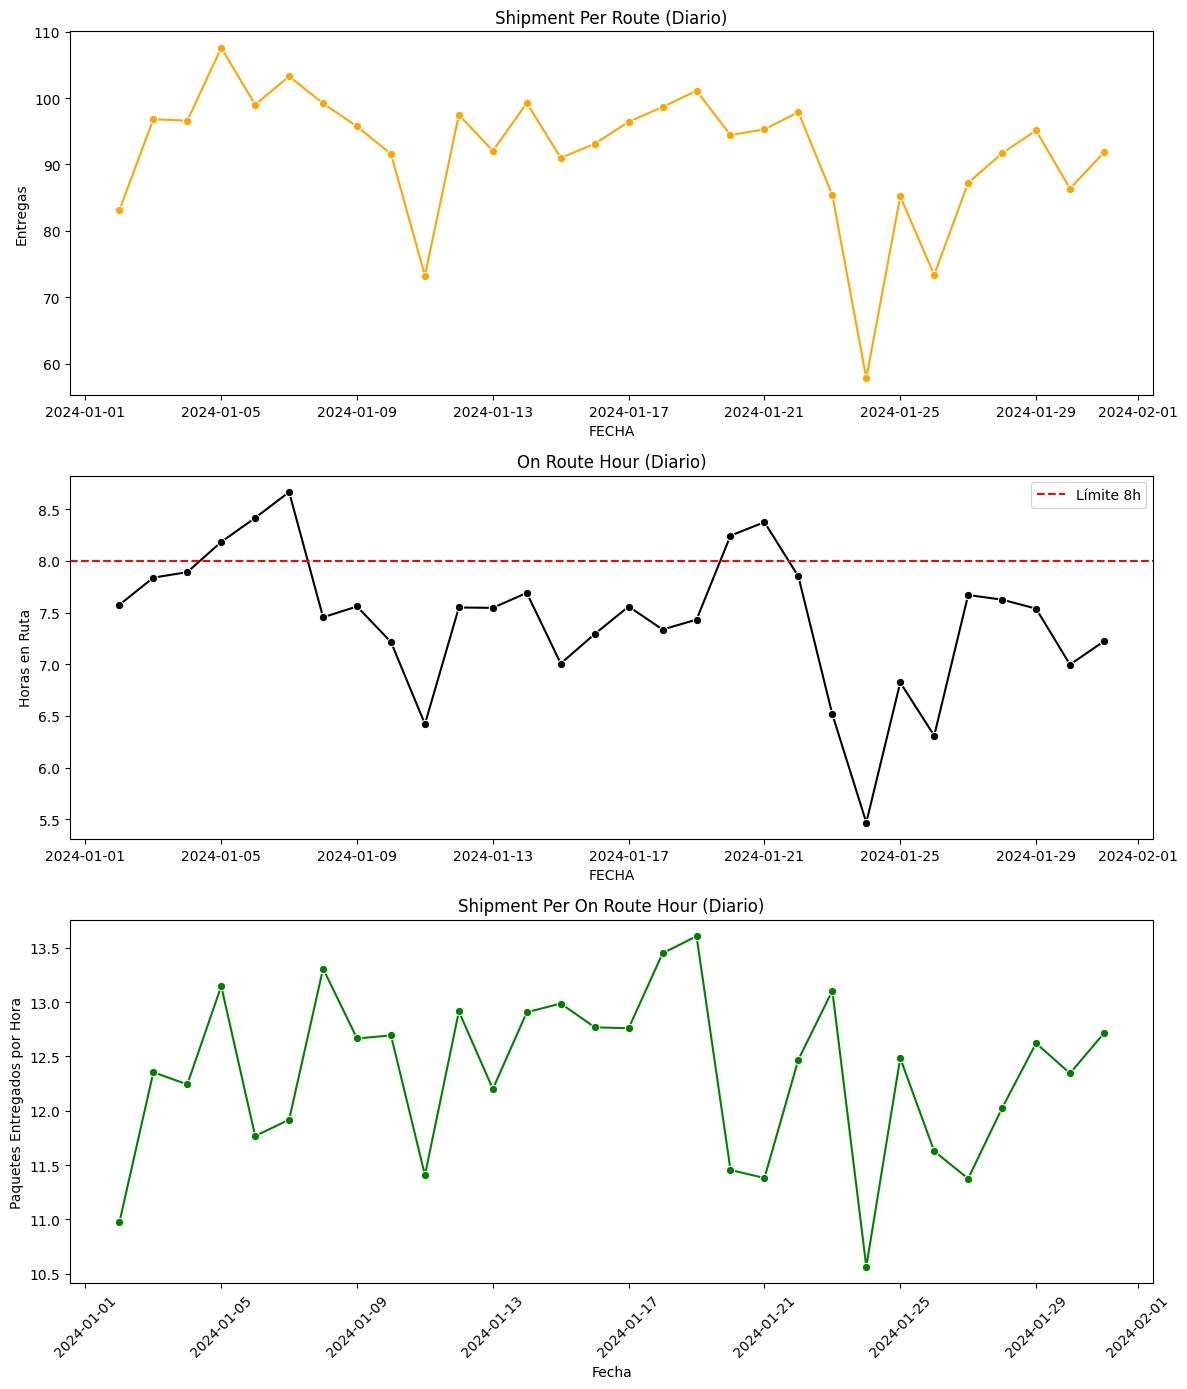

In [ ]:
# Definimos nuestro canva donde vamos a mostrar nuestras gráficas
# Definimos el tamaño de 3 x 1, el tamaño de cada uno de nuestros gráficos y sharex para indicar que todos comparten el eje X
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

# Graficamos SPR por día
sns.lineplot(data=metricas_diarias, x='FECHA', y='SPR', ax=axes[0], marker='o', color='orange')
axes[0].set_title('Shipment Per Route (Diario)')
axes[0].set_ylabel('Entregas')

# Graficamos ORH por día, esto nos sirve para ver que días se tuvo un ORH > 8 hrs
sns.lineplot(data=metricas_diarias, x='FECHA', y='ORH_DIA', ax=axes[1], marker='o', color= 'black')
axes[1].set_title('On Route Hour (Diario)')
axes[1].axhline(8, color='red', linestyle='--', label='Límite 8h')
axes[1].legend()
axes[1].set_ylabel('Horas en Ruta')

# Graficamos SPORH por día
sns.lineplot(data=metricas_diarias, x='FECHA', y='SPORH', ax=axes[2], marker='o', color='green')
axes[2].set_title('Shipment Per On Route Hour (Diario)')
axes[2].set_ylabel('Paquetes Entregados por Hora')
axes[2].set_xlabel('Fecha')

plt.tight_layout()
plt.show()

Shipments per Route (SPR)
Tendencia: creciente → hacia final de mes se ve un mayor número de envíos por ruta.
Interpretación: el site logró concentrar más volumen en menos rutas o mejorar la asignación, elevando la productividad por ruta.

On Route Hours (ORH)

Tendencia: ligeramente decreciente → se observa que hacia final de mes las rutas tienden a acercarse más al límite objetivo (≤8h), incluso reduciéndose en promedio.
Interpretación: hay un control operativo que está evitando que las rutas se extiendan demasiado, alineado con la política de calidad de vida de los drivers.

Shipments per On Route Hour (SPORH)

Tendencia: creciente → los drivers están entregando más paquetes por cada hora en ruta conforme avanza el mes.
Interpretación: la eficiencia por hora mejoró, lo que puede deberse a mejor planeación de rutas, consolidación de volumen o reducción de tiempos muertos.


aumentar productividad cuidando las horas de trabajo de los drivers, esto implica mejorar las rutas para así incrementar el numero de paquetes entregados

##### Definiendo SPR objetivo
----

* Con base en el resultado del SPORH de Enero, ¿Cuál debería de haber sido el SPR objetivo para SVR1?

In [35]:
# De la definición del caso de uso, sabemos que los drivers no deben pasar más de 8 horas en ruta por día, definimos que nuestro ORH = 8  
# Podemos calcular nuestro SPORH para enero con la información del mes, para ello obtenemos el promedio de SPORH de enero

OHR_MAXIMO = 8

sporh_enero = metricas_diarias['SPORH'].mean()

print(f"SPORH enero: {sporh_enero:.2f}")

SPORH enero: 12.34


In [36]:
# Si sabemos que SPORH = SPR / ORH -> SPR = SPORH * ORH

spr_objetivo = sporh_enero * OHR_MAXIMO

print(f"SPR objetivo: {round(spr_objetivo)}")

SPR objetivo: 99


* Del análisis anterior, podemos definir que el SPR objetivo para SVR1 en enero debería ser de apróximadamente **99 envíos/ruta**, sin perder de vista que se debe respetar que los drivers trabajen un máximo de **8 hrs por día**.
* El site debería fijarse como meta un aproximado de 99 envíos/ruta para febrero, manteniendo el equilibrio entre eficiencia y calidad de vida del driver.

##### Pronóstico de paquetes Febrero
----

* ¿Cuál sería el pronóstico de paquetes por día para la primera semana de febrero?

In [41]:
# Para este ejercicio se nos pide un pronóstico de paquetes enviados para la primera semana de febrero,
# para hacerlo simple utilicé una librería llamada prophet ya que considero de las más sencillas y a la vez útiles para realizar forecasts

# Trabajaremos con la información por día para el mes de Enero
# Prophet espera un atributo llamado ds y otro y para poder entrenar el modelo, es por eso que los nombramos de esta manera
shipments_por_dia = {'ds': pd.to_datetime(metricas_diarias['FECHA']),
        'y': metricas_diarias['SHIPMENTS_ENTREGADOS']}

shipments_df = pd.DataFrame(shipments_por_dia)

In [42]:
# Creamos nuestra instancia del modelo
model = Prophet()

# Ajustar el modelo con la información de enero
model.fit(shipments_df)

15:18:46 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
# Pedimos que realice el pronóstico de la información a futuro
# Le indicamos que el periodo será 7 días
info_febrero = model.make_future_dataframe(periods=7)

In [45]:
# Realiza las predicciones
forecast = model.predict(info_febrero)

In [46]:
# Podemos consultar la información que nos devuelve la predicción, el valor que tomamos como final es el yhat
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2024-01-02,10540.170838,9448.247409,11624.669977
1,2024-01-03,11377.951802,10320.817741,12480.663880
2,2024-01-04,14702.724084,13606.999292,15705.357936
3,2024-01-05,14391.978493,13330.938560,15526.953190
4,2024-01-06,12223.518369,11107.157757,13306.989924


In [47]:
# Como deseo graficar mis resultados, debo asegurarme que ambos atributos son del mismo tipo
metricas_diarias['FECHA'] = pd.to_datetime(metricas_diarias['FECHA']).dt.tz_localize(None)
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.tz_localize(None)

In [48]:
# No quiero graficar toda mi información del forecast, por eso solo filtro la información que está en las fechas de mi interes
periodo = (forecast['ds'] >= "2024-02-01") & (forecast['ds'] <= "2024-02-07")
forecast_feb = forecast.loc[periodo]

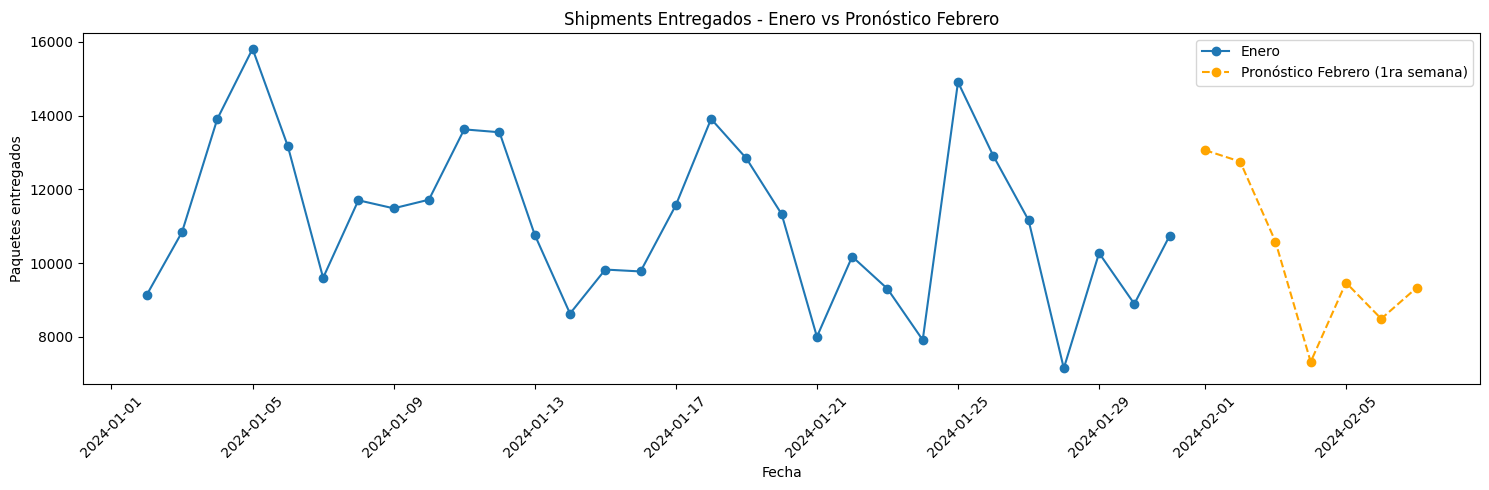

In [50]:
# Creamos una gráfica para tener más claridad de como podría fluctuar el número de paquetes entregados
plt.figure(figsize=(15,5))
plt.plot(metricas_diarias['FECHA'], metricas_diarias['SHIPMENTS_ENTREGADOS'], marker='o', label="Enero")
plt.plot(forecast_feb['ds'], forecast_feb['yhat'], marker='o', linestyle='--', color='orange', label="Pronóstico Febrero (1ra semana)")
plt.title("Shipments Entregados - Enero vs Pronóstico Febrero")
plt.xlabel("Fecha")
plt.ylabel("Paquetes entregados")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

##### Unidades requeridas
----

* De acuerdo al SPR objetivo definido en el punto 2 y al pronóstico del punto 3, ¿Cuántas unidades se van a requerir por día para entregar los paquetes?

In [51]:
# Como primer paso necesito conocer el promedio del número de paquetes que se entregarán la primera semana de Febrero
avg_feb = forecast_feb['yhat'].mean()

In [52]:
# Considerando la información obtenida en los ejercicios previos, tenemos que:

# El SPR objetivo definido para cada ruta en promedio
print(f"SPR objetivo: {spr_objetivo:.2f}")

# Teniendo en cuenta que el pronóstico que realizamos fue con el mismo valor para toda la semana de febrero
print(f"Promedio de paquetes entregados en Febrero: {avg_feb:.2f}")


# Sabiendo que las Unidades (rutas) requeridas  = paquetes pronosticados / spr objetivo
print(f"\nUnidades requeridas: { round((avg_feb / spr_objetivo))}")

SPR objetivo: 98.73
Promedio de paquetes entregados en Febrero: 10146.65

Unidades requeridas: 103


* 103 unidades serán requeridas para...........

##### Áreas de oportunidad
----

* Realiza un **deep dive** para identificar las **áreas de oportunidad** de la operación y explica las propuestas de mejora que darías al equipo.

In [ ]:
## Varias rutas con ORH > 8 horas, lo que sugiere sobreasignación de volumen.

In [102]:
# Asegurar que fecha sea datetime
shipments_por_ruta["fecha"] = pd.to_datetime(shipments_por_ruta["fecha"])

# Crear indicador de rutas largas
shipments_por_ruta["rutas_largas"] = shipments_por_ruta["horas_ruta"] > 8

# Obtener día de la semana
shipments_por_ruta["dia_semana"] = shipments_por_ruta["fecha"].dt.day_name(locale="es_MX")

# Agrupar por fecha y condición
conteo = (
    shipments_por_ruta
    .groupby(["fecha", "dia_semana", "rutas_largas"])["route_id"]
    .nunique()
    .reset_index()
)

# Reorganizar columnas: rutas <=8h y >8h
tabla = conteo.pivot(
    index=["fecha", "dia_semana"],
    columns="rutas_largas",
    values="route_id"
).fillna(0)

tabla.columns = ["rutas_<=8h", "rutas_>8h"]

# Calcular totales y porcentajes
tabla["total_rutas"] = tabla["rutas_<=8h"] + tabla["rutas_>8h"]

In [103]:
tabla

,,rutas_<=8h,rutas_>8h,total_rutas
fecha,dia_semana,,,
2024-01-02,Martes,62,48,110
2024-01-03,Miércoles,58,54,112
2024-01-04,Jueves,74,70,144
2024-01-05,Viernes,64,83,147
2024-01-06,Sábado,56,77,133
2024-01-07,Domingo,39,54,93
2024-01-08,Lunes,67,51,118
2024-01-09,Martes,64,56,120
2024-01-10,Miércoles,87,41,128


In [104]:
tabla['rutas_<=8h'].sum() / tabla['total_rutas'].sum() * 100

np.float64(61.64942841589548)

In [105]:
tabla['rutas_>8h'].sum() / tabla['total_rutas'].sum() * 100

np.float64(38.35057158410452)

Del total de 3,674 rutas analizadas, aproximadamente 38% exceden las 8 horas.

Esto implica que 1 de cada 3 rutas está por encima del umbral recomendado, afectando:

Eficiencia operativa (más horas por entrega).

Calidad de vida de los drivers (jornadas extendidas).

Satisfacción del cliente (mayor riesgo de retrasos).

In [ ]:
# rutas de baja densidad

In [110]:
# Definimos umbrales:
umbral_paquetes = productividad["shipments_entregados"].mean()  # rutas con pocos paquetes
umbral_horas = 8  # límite natural de jornada

# Filtro de rutas de baja densidad:
rutas_baja_densidad = productividad[
    (productividad["shipments_entregados"] < umbral_paquetes) &
    (productividad["ORH"] > umbral_horas)
]

# Resumen por fecha para ver la magnitud del problema
resumen_baja_densidad = (
    rutas_baja_densidad.groupby("fecha")["route_id"]
    .nunique()
    .reset_index()
    .rename(columns={"route_id": "rutas_baja_densidad"})
)


In [111]:
rutas_baja_densidad.head()

,fecha,service_center,ciclo,route_id,vehículo_plan,vehículo_real,carrier,experiencia_del_driver,delivery_model,shipments_planeados,shipments_despachados,shipments_entregados,ORH,SPORH,excede_horas
41,2024-01-02,SVR1,C1,57661942,Large Van,Small Van,portos logistica,Experienced,MLP,98,98,89,10.0433,8.861629,1
46,2024-01-02,SVR1,C1,57662355,Other,Walker,KANGU,Veteran,DELIVERY CELL,64,64,62,8.9272,6.945067,1
49,2024-01-02,SVR1,C1,57662411,Other,Walker,KANGU,Veteran,DELIVERY CELL,45,45,44,9.8164,4.482295,1
52,2024-01-02,SVR1,C1,57662488,Other,Walker,KANGU,Veteran,DELIVERY CELL,62,62,61,8.7650,6.959498,1
57,2024-01-02,SVR1,C1,57662579,Other,Walker,KANGU,Experienced,DELIVERY CELL,79,79,78,9.6317,8.098259,1


In [112]:
resumen_baja_densidad.head()

,fecha,rutas_baja_densidad
0,2024-01-02,19
1,2024-01-03,18
2,2024-01-04,25
3,2024-01-05,15
4,2024-01-06,23


Impacto en eficiencia operativa

Estas rutas representan, por ejemplo, entre 18%–22% del total diario (según el cálculo).

Están consumiendo muchas horas de los conductores, pero con bajo volumen de entregas.

Esto implica alto costo por paquete entregado, menor productividad y posible desgaste innecesario de drivers.

Calidad de vida de los conductores

Drivers asignados a estas rutas trabajan largas jornadas con pocos paquetes, lo cual no se traduce en mejor desempeño ni mayor retribución.

Genera frustración, menor satisfacción laboral y mayor rotación.

Oportunidad de rediseño logístico

Al consolidar estas zonas o redistribuir volumen, se puede reducir horas muertas y aprovechar la capacidad instalada.

Potencial de optimizar el ruteo y balancear carga de trabajo.



“Identificamos que aproximadamente 20% de las rutas son de baja densidad, es decir, ocupan más de 8 horas con un volumen reducido de paquetes. Esto implica costos altos por entrega y afecta la calidad de vida de los drivers. Al consolidar zonas y redistribuir el volumen, podemos reducir significativamente esas horas improductivas, mejorar la experiencia de los conductores y generar ahorros en costos logísticos.”

In [113]:
productividad.columns

Index(['fecha', 'service_center', 'ciclo', 'route_id', 'vehículo_plan',
       'vehículo_real', 'carrier', 'experiencia_del_driver', 'delivery_model',
       'shipments_planeados', 'shipments_despachados', 'shipments_entregados',
       'ORH', 'SPORH', 'excede_horas'],
      dtype='object')

In [115]:
# Careers 

In [116]:
# Agrupamos por carrier
carrier_perf = productividad.groupby("carrier").agg(
    rutas=("route_id", "nunique"),
    total_paquetes=("shipments_entregados", "sum"),
    total_horas=("ORH", "sum")
).reset_index()

# SPORH (shipments per hour)
carrier_perf["SPORH"] = carrier_perf["total_paquetes"] / carrier_perf["total_horas"]
carrier_perf["paquetes_por_ruta"] = carrier_perf["total_paquetes"] / carrier_perf["rutas"]
carrier_perf["horas_promedio_ruta"] = carrier_perf["total_horas"] / carrier_perf["rutas"]

# Top 5 mejores carriers (más productivos en SPORH)
top_carriers = carrier_perf.sort_values("SPORH", ascending=False).head(5)

# Bottom 5 peores carriers
bottom_carriers = carrier_perf.sort_values("SPORH", ascending=True).head(5)


In [117]:
top_carriers

,carrier,rutas,total_paquetes,total_horas,SPORH,paquetes_por_ruta,horas_promedio_ruta
9,READY TO LEASE,228,24300,1681.4469,14.451839,106.578947,7.374767
5,KANGU,547,48869,3443.0019,14.193719,89.340037,6.294336
0,99minutos,35,3301,238.2436,13.855566,94.314286,6.806960
3,FEXCO,156,13097,985.7372,13.286503,83.955128,6.318828
1,Delserva,717,69470,5399.1035,12.866951,96.889819,7.530130


In [118]:
bottom_carriers

,carrier,rutas,total_paquetes,total_horas,SPORH,paquetes_por_ruta,horas_promedio_ruta
6,MS FLEET SERVICES,16,300,97.5420,3.075598,18.750000,6.096375
2,Envíos Extra,130,5505,681.8197,8.073982,42.346154,5.244767
10,STED Traslados,9,791,84.1081,9.404564,87.888889,9.345344
8,Movicity,16,1649,167.2707,9.858272,103.062500,10.454419
7,Milla Logistics,64,5154,445.6491,11.565153,80.531250,6.963267


#### Dispersión de Volumen (Parte 2)
----

In [ ]:
# Conociendo nuestra información 
location.head()

,SHP_LG_RELATED_FACILITY_ID,START_ZC,zip_longitude,zip_latitude,geometry,SHP_CITY_NAME,SHP_STATE_NAME,total,Prom,Max_Daily_Shipments
0,SVR1,95847,-95.352822,18.569143,"POLYGON((-95.3692758177252 18.5078260341524, -...",Catemaco,Veracruz,588.0,19.600000,51.0
1,SVR1,91808,-96.224770,19.210587,"POLYGON((-96.2053731187867 19.196775659543, -9...",Veracruz,Veracruz,12410.0,413.666667,600.0
2,SVR1,94298,-96.109577,19.136823,"POLYGON((-96.1015178681995 19.1411388604368, -...",Veracruz,Veracruz,4432.0,147.733333,226.0
3,SVR1,94240,-96.422723,19.046667,"POLYGON((-96.4191676313639 19.0441850594805, -...",Veracruz,Veracruz,1691.0,56.366667,90.0
4,SVR1,95226,-96.210662,18.783540,"POLYGON((-96.1597915292763 18.8418481026875, -...",Veracruz,Veracruz,2344.0,78.133333,119.0


In [54]:
location.shape

(497, 10)

In [ ]:
# Podemos observar que tenemos algunos valores nulos que pueden afectar nuestro análisis
location.isnull().sum()

SHP_LG_RELATED_FACILITY_ID     0
START_ZC                       0
zip_longitude                 35
zip_latitude                  35
geometry                      35
SHP_CITY_NAME                  0
SHP_STATE_NAME                 0
total                         86
Prom                          86
Max_Daily_Shipments           86
dtype: int64

In [57]:
location['SHP_LG_RELATED_FACILITY_ID'].value_counts()

SHP_LG_RELATED_FACILITY_ID
SVR1    497
Name: count, dtype: int64

In [58]:
location['SHP_STATE_NAME'].value_counts()

SHP_STATE_NAME
Veracruz    497
Name: count, dtype: int64

In [60]:
# Limpiamos nuestra información, borramos aquellos registros donde no tenemos latitud, longitud o total de paquetes
location = location.dropna(
    subset=["zip_latitude","zip_longitude","total"]
).copy()

In [61]:
# Calculamos la ubicación óptima del Service Center, consideré que algo sencillo para esta prueba podría ser usar un............
lat_optima = (location["zip_latitude"] * location["total"]).sum() / location["total"].sum()
lon_optima = (location["zip_longitude"] * location["total"]).sum() / location["total"].sum()

In [62]:
# Coordenadas de nuestros puntos de interes
SVC_ACTUAL = [19.179527, -96.255193]
svc_propuesto = [lat_optima, lon_optima]

print("Ubicación actual (lat, lon):", SVC_ACTUAL)
print("Ubicación propuesta (lat, lon):", svc_propuesto)

Ubicación actual (lat, lon): [19.179527, -96.255193]
Ubicación propuesta (lat, lon): [np.float64(18.912385169386138), np.float64(-96.05341979666379)]


In [63]:
# Hacemos uso de folium para crear nuestro mapa
mapa = folium.Map(location=SVC_ACTUAL, zoom_start=8)

In [ ]:
# Para que fuera más claro de manera visual, decidí usar un mapa de calor para identificar el volumen de paquetes por zona
from folium.plugins import HeatMap
heat_data = location[["zip_latitude", "zip_longitude", "total"]].values.tolist()

# Creamos nuestro mapa de calor y lo añadimos 
HeatMap(heat_data, radius=15).add_to(mapa)

In [71]:
# Agregamos nuestro puntos de interes al mapa

# Ubicación actual
folium.Marker(
    location=SVC_ACTUAL,
    popup="SVC Actual",
    icon=folium.Icon(color="blue", icon="fa_star")
).add_to(mapa)

# Ubicación propuesta
folium.Marker(
    location=svc_propuesto,
    popup="SVC Propuesto",
    icon=folium.Icon(color="red", icon="flag")
).add_to(mapa)

In [72]:
# Guardar mapa
mapa.save("./OUTPUTS/paquetes_veracruz.html")